In [17]:
# !pip install earthengine-api

In [18]:
import ee

In [19]:
# Trigger the authentication flow. if you want to user json, please comment this
ee.Authenticate()
# Initialize the library
# ee.Initialize(project='bukit30project')
ee.Initialize(project='ee-iwansetiawan')

In [20]:
# !pip install geemap

In [21]:
import sys
import os
import json

# variable
# Connect to the path of the module
module_path = r'C:\Users\q_bal\Documents\Github\GEE_notebook_Forestry'
map_name_arcgis_pro = 'eligibility_check_prospective_tpps'
create_training_gee = False

# Add the module path to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)
    
current_dir = os.path.join(module_path,"osi/qgis")
print('current_dir: ',current_dir)

# Move to the parent directory of the current script
parent_dir = os.path.dirname(current_dir)

# Construct the absolute path to the JSON file in the 'input' folder
json_path= os.path.join(parent_dir, '00_input', 'balaban_conf.json')

# Read and load the JSON data from the file
with open(json_path, 'r') as file:
    config = json.load(file)

print('config---> ',config)


current_dir:  C:\Users\q_bal\Documents\Github\GEE_notebook_Forestry\osi/qgis
config--->  {'module_path': 'C:/Users/q_bal/Documents/Github/GEE_notebook_Forestry', 'I_satellite': 'Planet', 'pca_scaling': 1, 'tileScale': 1, 'AOI_path': 'G:/Shared drives/TREEO BD Supply/satellite_verification/PPP/LPHD Belaban Rayak.shp', 'OID_field_name': 'id', 'input_training': 'G:/Shared drives/TREEO BD Supply/satellite_verification/PPP/traning_point_merged_belaban.shp', 'algo_ml_selected': 'gbm', 'date_start_end': ['2024-5-1', '2024-5-31'], 'project_name': 'belaban_rayak', 'super_pixel_size': 3, 'region': 'asia', 'pixel_number': 3, 'year_start_loss': 14, 'tree_cover_forest': 30, 'band_name_image': 'Class', 'cloud_cover_threshold': 40, 'crs_input': 'EPSG:4326', 'IsThermal': False, 'fcd_selected': 21, 'high_forest': 65, 'yrf_forest': 45, 'shrub_grass': 45, 'open_land': 30, 'ndwi_hi_sentinel': 0.05, 'ndwi_hi_landsat': 0.1, 'ndwi_hi_planet': -0.2}


In [22]:
# import main library
import ee
import geemap
import osi
import pandas as pd

from osi.utils.main import validate_aoi
# convert the modules for image collection (cloudless masking, compositing, reducer etc)
from osi.image_collection.main import ImageCollection
from osi.spectral_indices.spectral_analysis import SpectralAnalysis
from osi.spectral_indices.utils import normalization_100
from osi.hansen.historical_loss import HansenHistorical
from osi.classifying.assign_zone import AssignClassZone
from osi.legends.utils import convert_to_legend_items
from osi.legends.main import LegendsBuilder
from osi.obia.main import OBIASegmentation
from osi.ml.main import LandcoverML
from osi.arcpy.main import ArcpyOps
from osi.fcd.main_fcd import FCDCalc
from osi.pca.pca_gee import PCA
from osi.hansen.historical_loss import HansenHistorical
from osi.classifying.assign_zone import AssignClassZone
from osi.arcpy.utils import safe_get_data_source


AOIt_shp_plot = geemap.shp_to_ee(config['AOI_path'])
crs_input = config['crs_input']
I_satellite = config['I_satellite']
project_name = config['project_name']

start_date = config['date_start_end'][0]
end_date = config['date_start_end'][1]

layer_name_image_mosaick = f'image_mosaick_result_ee_{project_name}'

AOI = AOIt_shp_plot
config['AOI'] = AOI

ndwi_hi = 0.1
if config['I_satellite'] == 'Landsat':
    ndwi_hi = config['ndwi_hi_landsat']
elif I_satellite == 'Sentinel':
    ndwi_hi = config['ndwi_hi_sentinel']
elif I_satellite == 'Planet':
    ndwi_hi = config['ndwi_hi_planet']

### Masking and overlay and area helper Make an image out of the AOI area attribute -> convert featurecollection into raster (image) for overlaying tools
OID = config['OID_field_name']
AOI_img = AOI.filter(ee.Filter.notNull([OID])).reduceToImage(
    properties= [OID],
    reducer= ee.Reducer.first()
)


In [23]:
# !pip install pycrs

In [24]:
# ADD FIRST AOI TO ARCGIS MAP - option-1 in using existing shp to geemap
# aoi_layer_name_in_map_arcgis = 'aoi_extent_delight'

# USE THE PATH FOR TRAINING DATA - option-2 in using existing shp to geemap
# path_shp_input_training = r'G:\Shared drives\TREEO BD Supply\02. UGA\01. TPPs\03. Delight Ltd\Due Diligence\2024_07_24_Updated_Satellite_Assessment\raw_data_shp_script\00_input\training_aoi_smaller.shp'

In [25]:
# empower the capability of arcpy, native arcgis scripting from a class made
# Open the currently active project, you can also refer to actual project path, comment here below, and activate after
project_path = "CURRENT"
# project_path = r'G:\My Drive\TreeO_WORKS\GIS_data\ArcGIS_Pro\TREEO\TREEO.aprx'
arc_ops= ArcpyOps(project_path_arcgis = project_path, map_name_arcgis= map_name_arcgis_pro)
map = arc_ops.map
# layer_aoi = arc_ops.selecting_layer(name_layer = aoi_layer_name_in_map_arcgis)
AOIt_shp = arc_ops.select_adding_layer(config['AOI_path'])['layer_path']
AOI = geemap.shp_to_ee(AOIt_shp)

we will select the map for eligibility_check_prospective_tpps
layer of G:/Shared drives/TREEO BD Supply/satellite_verification/PPP/LPHD Belaban Rayak.shp is already added, check it on the map, save it in the same path if you edited


In [26]:
# os.path.normpath(config['AOI_path']) not in arc_ops.list_source_layers_in_map

In [27]:
# lets print below the layer and convert into df if field names is exist
# Get the layer's attribute table fields
layer_aoi_arc = arc_ops.select_adding_layer(config['AOI_path'])['layer']
fields = [field.name for field in arcpy.ListFields(layer_aoi_arc)]

# Initialize an empty list to hold the data
data = []

# Use a SearchCursor to iterate over the rows in the attribute table
with arcpy.da.SearchCursor(layer_aoi_arc, fields) as cursor:
    for row in cursor:
        data.append(row)

# Create a pandas DataFrame from the data
df = pd.DataFrame(data, columns=fields)
display(df)

#for area id in shapefile that identified the data, and will converted into raster
OID = config['OID_field_name']  #IMPORTANT TO CHECK OID based on the column ID
if OID not in fields:
    print(f'field_name of {OID} is not exist ERROR WILL HAPPEN!!!!')
    raise ValueError(f"Field '{OID}' not found in the fields: {fields}")
else:
    print(f"Field '{OID}' found. Proceeding with operations masking based on AOI \nplease continue")
    # Proceed with further operations, like converting to raster, etc.
    #############################################
    ##################################################################################
    ### Masking and overlay and area helper Make an image out of the AOI area attribute -> convert featurecollection into raster (image) for overlaying tools
    AOI_img = AOI.filter(ee.Filter.notNull([OID])).reduceToImage(
        properties= [OID],
        reducer= ee.Reducer.first()
    )

layer of G:/Shared drives/TREEO BD Supply/satellite_verification/PPP/LPHD Belaban Rayak.shp is already added, check it on the map, save it in the same path if you edited


,FID,Shape,FID_1,kode_prov,kode_kab,hd_id,nama_kec,nama_desa,nama_ld,no_sk_pphd,tgl_sk_pph,no_sk_pak_,tgl_sk_pak,luas_hl,luas_hpt,luas_hp,luas_hpk,luas_pphd,st_area_sh,st_length_,A1NAME,A1CODE,A2CODE,A2NAME,TYPE,A2TEXT,Hectares,id
0,0,"(12296692.253643373, -200833.35952928432)",554.0,61.0,6104.0,610418.0,Sungai Melayu Rayak,Sungai Melayu,LPHD Belaban Rayak,SK.4670/MENLHK-PSKL/PKPS/PSL.0/7/2018,2018/07/06 08:00:00.000,-,-,3383.0,0.0,0.0,0.0,3383.0,0.002752,0.229771,KALIMANTAN BARAT,61.0,6106.0,KETAPANG,Kabupaten,6106,3385.72723,0


Field 'id' found. Proceeding with operations masking based on AOI 
please continue


In [29]:
# smarter way to check
print('validate the AOI input: ')
validate_aoi(AOI, ee, config['OID_field_name'])

arc_ops.list_layers = map.listLayers()
arc_ops.list_source_layers_in_map = [safe_get_data_source(layer) for layer in arc_ops.list_layers]
input_training = arc_ops.select_adding_layer(config['input_training'])['layer_path']
input_training_ee = geemap.shp_to_ee(config['input_training'])

print('validate input training points')
fields_input_training = [field.name for field in arcpy.ListFields(input_training)]

# Initialize an empty list to hold the data
data_input_training = []

# Use a SearchCursor to iterate over the rows in the attribute table
with arcpy.da.SearchCursor(input_training, fields_input_training) as cursor:
    for row in cursor:
        data_input_training.append(row)

# Create a pandas DataFrame from the data
df = pd.DataFrame(data_input_training, columns=fields_input_training)
print('before_validation: ',df.shape)
# Function to check if a value is an integer
def is_integer(value):
    return isinstance(value, int)

# Filter out non-integer values in the 'code_lu' column
df['code_lu'] = df['code_lu'].apply(lambda x: x if is_integer(x) else None)
display(df)
print('after validation: ',df.shape)

validate the AOI input: 
trying to list the featurecollection
now for loop to feature size range
All features have a valid "id" column with integer values.
layer of G:/Shared drives/TREEO BD Supply/satellite_verification/PPP/traning_point_merged_belaban.shp is already added, check it on the map, save it in the same path if you edited
validate input training points
before_validation:  (200, 5)


,FID,Shape,id,cd,code_lu
0,0,"(12298837.387797227, -200304.00237333647)",0,3,3
1,1,"(12293945.341936655, -202216.47258877862)",1,4,4
2,2,"(12297955.557603471, -200834.47418906735)",2,1,1
3,3,"(12296728.038661005, -202186.20629604792)",3,1,1
4,4,"(12295262.999174526, -199212.03719895022)",4,1,1
...,...,...,...,...,...
195,195,"(12299589.276132282, -202026.49348096154)",195,4,4
196,196,"(12294414.127457334, -198748.18544829503)",196,3,3
197,197,"(12295901.055777473, -202159.81213440988)",197,1,1
198,198,"(12296042.34700979, -201160.85203447298)",198,1,1


after validation:  (200, 5)


In [30]:
# [f.name for f in map.listLayers()]

In [31]:
# [f.name for f in arc_ops.list_layers]

In [32]:
# now starting to do analysis
# initiate instance class for the image collection and later mosaicking
classInputCollection = ImageCollection(I_satellite=I_satellite,
                                       AOI=AOI, 
                                       date_start_end=config['date_start_end'], 
                                       cloud_cover_threshold = config['cloud_cover_threshold'],
                                       region=config['region'])

In [33]:
# run the method from image collection loaded, cloudless compositing until to image_mosaick
image_mosaick = classInputCollection.image_mosaick()

selecting Planet images


In [34]:
arc_ops.list_layers = map.listLayers()
arc_ops.list_source_layers_in_map = [safe_get_data_source(layer) for layer in arc_ops.list_layers]

vis_params_image_mosaick = {"bands":["red","green","blue"],"min":0,"max":0.1,"gamma":1}
layer_name_image_mosaick = f'image_mosaick_result_ee_{config["project_name"]}'
# image_mosaick_arcgis_layer = arc_ops.adding_ee_to_arcgisPro(image_mosaick, vis_params_image_mosaick,
#                                                    layer_name_image_mosaick)
image_mosaick_arcgis_layer = None

if config['I_satellite'] == 'Planet':
    # true color {"bands":["red","green","blue"],"min":0,"max":0.6,"gamma":1.5}
    # nir veg color {"bands":["red","nir","blue"],"min":0,"max":0.6,"gamma":1.5 }
    image_mosaick_arcgis_layer = arc_ops.adding_ee_to_arcgisPro(image_mosaick,{"bands":["red","green","blue"],"min":0,"max":0.6,"gamma":1.5}, f'{I_satellite} mosaicked - {start_date}-{end_date} VegColor')
else:
    image_mosaick_arcgis_layer = arc_ops.adding_ee_to_arcgisPro(image_mosaick,{'bands': ['swir2', 'nir', 'red'], 'min': 0, 'max': 0.6, 'gamma': 1.5 }, f'{I_satellite} mosaicked - {start_date}-{end_date}')
   


https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/8ed176a8d683fdd7938384e73606c7ea-90d091d685154a4e450bd336497b941d/tiles/{z}/{x}/{y}
removing and re-adding the layer name: Planet mosaicked - 2024-5-1-2024-5-31 VegColor
layer re-added: Planet mosaicked - 2024-5-1-2024-5-31 VegColor


In [35]:
arc_ops.list_layers = map.listLayers()
arc_ops.list_source_layers_in_map = [safe_get_data_source(layer) for layer in arc_ops.list_layers]

classImageSpectral = SpectralAnalysis(image_mosaick,config)
class_FCD_run = FCDCalc(config).fcd_calc()
FCD1_1 = class_FCD_run['FCD1_1']
FCD2_1 = class_FCD_run['FCD2_1']

FCD1_1_arcgis_layer = arc_ops.adding_ee_to_arcgisPro(FCD1_1, {'min':0 ,'max':80, 'palette':['ff4c16', 'ffd96c', '39a71d']},
                                                   f'FCD1_1_{project_name}')

FCD2_1_arcgis_layer = arc_ops.adding_ee_to_arcgisPro(FCD2_1, {'min':0 ,'max':80, 'palette':['ff4c16', 'ffd96c', '39a71d']},
                                                   f'FCD2_1_{project_name}')

print('finish processing PCA please continue')

selecting Planet images
selecting Planet images
processing AVI
processing BSI
processing SI
Normalizing to 100 AVI
Normalizing to 100 AVI
Normalizing to 100 BSI
Normalizing to 100 SI
Combining AVI AND BSI
no thermal band, choosing Planet images
Processing means center of AVI_BSI please wait
Now we proceed to the PCA of Vegetation density
Success get the PCA normalized of VD => SVI
Now calculating the FCD from SVI and SSI - selecting band svi1 svi2 ssi1 and ssi2
finish processing PCA, the result: FCD1_1 and FCD2_1 please continue
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/7a564a70d7a3a696cf1de6d9e9c6b1e2-bc186bdf0b8399dcad5e0984a294f4a8/tiles/{z}/{x}/{y}
removing and re-adding the layer name: FCD1_1_belaban_rayak
layer re-added: FCD1_1_belaban_rayak
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/a0e6ade221f2cad3d436812ebbd5482b-3e2bfa3e54b761d49ddfc2e13e5e8a6f/tiles/{z}/{x}/{y}
removing and re-adding the layer name: FCD2_1_belaban_rayak
laye

In [36]:
# Now this is historical data to overlay later with current baseline (landcover)
hansen_class = HansenHistorical(config)
run_hansen = hansen_class.initiate_tcl()
LastImageLandsat, treeLossYear, minLoss, ForestArea2000Hansen, gfc =  \
                                 run_hansen['LastImageLandsat'], \
                                 run_hansen['treeLossYear'], \
                                 run_hansen['minLoss'], \
                                 run_hansen['ForestArea2000Hansen'], \
                                 run_hansen['gfc']


In [37]:
arc_ops.list_layers = map.listLayers()
arc_ops.list_source_layers_in_map = [safe_get_data_source(layer) for layer in arc_ops.list_layers]

config['AOI_img'] = AOI_img

class_assigning_fcd =  AssignClassZone(config, FCD1_1=FCD1_1, FCD2_1=FCD2_1)
list_images_classified = class_assigning_fcd.assigning_fcd_class(gfc, minLoss)

fcd_classified_zone = list_images_classified['all_zone']

vis_params_fcd_classified = class_assigning_fcd.vis_param_merged
# Convert the dictionary to the LEGEND_ITEMS format
legend_items = convert_to_legend_items(class_assigning_fcd.legend_class)

fcd_classified_zone_arcgis_layer = arc_ops.adding_ee_to_arcgisPro(fcd_classified_zone, vis_params_fcd_classified,
                                                   f'FCD_classified_zone_{project_name}')

Adding the map of Forest, FCD >= 45% and mask only if not water in area (hansen) and NDWI
Adding the map of Shrubland, FCD <  45% and FCD >= 45%
Adding the map of Grassland or Openland, FCD  < 45%
Processing - the zoning classification
finish processing, merging all the zone into one image
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/a089b991bc97d5dbec96efce49584e4e-97851c617a3defa5fa024ccfe38b461f/tiles/{z}/{x}/{y}
removing and re-adding the layer name: FCD_classified_zone_belaban_rayak
layer re-added: FCD_classified_zone_belaban_rayak


In [38]:
## ADDING DIRECTLY SPECTRAL INDICES
# classImageSpectral
pca_scale = classImageSpectral.pca_scale #pca_scale is spatial resolution. eg planet: 5
ndwi_image = classImageSpectral.NDWI_func()
msavi2_image = classImageSpectral.MSAVI2_func()
mtvi2_image = classImageSpectral.MTVI2_func()
ndvi_image = classImageSpectral.NDVI_func()
vari_image = classImageSpectral.VARI_func()

image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari = (
    image_mosaick
    .addBands(ndwi_image)
    .addBands(msavi2_image)
    .addBands(mtvi2_image)
    .addBands(ndvi_image)
    .addBands(vari_image)
)

red_norm = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select(['red']), pca_scale=pca_scale, AOI=AOI)
green_norm = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select(['green']), pca_scale=pca_scale, AOI=AOI)
blue_norm = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select(['blue']), pca_scale=pca_scale, AOI=AOI)
nir_norm = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select(['nir']), pca_scale=pca_scale, AOI=AOI)

image_norm = red_norm.addBands(green_norm).addBands(blue_norm).addBands(nir_norm)

image_norm_ndvi = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('NDVI'), pca_scale=pca_scale, AOI=AOI)
image_norm_ndwi = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('ndwi'), pca_scale=pca_scale, AOI=AOI)
image_norm_msavi2 = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('msavi2'), pca_scale=pca_scale, AOI=AOI)
image_norm_mtvi2 = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('MTVI2'), pca_scale=pca_scale, AOI=AOI)
image_norm_vari = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('VARI'), pca_scale=pca_scale, AOI=AOI)

# red_norm.bandNames().getInfo()
image_norm_with_spectral_indices = image_norm.addBands(image_norm_ndvi).addBands(image_norm_ndwi).addBands(image_norm_msavi2).addBands(image_norm_mtvi2).addBands(image_norm_vari)
image_norm_with_spectral_indices_FCD = image_norm_with_spectral_indices.addBands(FCD2_1.select('FCD').rename('FCD2_1')).addBands(FCD1_1.select('FCD').rename('FCD1_1'))


In [39]:
obia = OBIASegmentation(config=config, image=image_norm_with_spectral_indices_FCD, pca_scale=pca_scale) #pca_scale basically is spatial resolution e.g planet: 5
clusters = obia.SNIC_cluster()['clusters']
object_properties_image = obia.summarize_cluster(is_include_std = False)

lc = LandcoverML(config=config,
                 input_image = image_norm_with_spectral_indices_FCD,
                cluster_properties=object_properties_image,
                pca_scale = pca_scale)

classifier = lc.run_classifier()

legend_lc = lc.lc_legend_param()
vis_param_lc = legend_lc['vis_param_lc']

legend_lc = legend_lc['legend_class']
# Convert the dictionary to the LEGEND_ITEMS format
legend_items_lc = convert_to_legend_items(legend_lc)

training_points = classifier['training_points']
validation_points = classifier['validation_points']

rf = classifier['classified_image_rf']
svm = classifier['classified_image_svm']
gbm = classifier['classified_image_gbm']
cart = classifier['classified_image_cart']

# fcd lc, 5 classes only, just nice to know
fcd_lc = list_images_classified['fcd_class_lc_image']
fcd_lc_vs = list_images_classified['vis_param_segment_lc']

snic list bands: ['red_mean', 'green_mean', 'blue_mean', 'nir_mean', 'ndwi_mean', 'msavi2_mean', 'MTVI2_mean', 'NDVI_mean', 'VARI_mean', 'FCD1_1_mean', 'FCD2_1_mean', 'area', 'clusters_min', 'width', 'height']


In [40]:
image_mosaick_all_bands = image_mosaick.addBands([FCD2_1.select('FCD').rename('FCD2_1'), FCD1_1.select('FCD').rename('FCD1_1')])

## ADDING DIRECTLY SPECTRAL INDICES
# classImageSpectral
pca_scale = classImageSpectral.pca_scale
ndwi_image = classImageSpectral.NDWI_func()
msavi2_image = classImageSpectral.MSAVI2_func()
mtvi2_image = classImageSpectral.MTVI2_func()
ndvi_image = classImageSpectral.NDVI_func()
vari_image = classImageSpectral.VARI_func()

image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari = (
    image_mosaick_all_bands
    .addBands(ndwi_image)
    .addBands(msavi2_image)
    .addBands(mtvi2_image)
    .addBands(ndvi_image)
    .addBands(vari_image)
)

red_norm = normalization_100(image_mosaick.select(['red']), pca_scale=pca_scale, AOI=AOI)
green_norm = normalization_100(image_mosaick.select(['green']), pca_scale=pca_scale, AOI=AOI)
blue_norm = normalization_100(image_mosaick.select(['blue']), pca_scale=pca_scale, AOI=AOI)
nir_norm = normalization_100(image_mosaick.select(['nir']), pca_scale=pca_scale, AOI=AOI)

image_norm = red_norm.addBands(green_norm).addBands(blue_norm).addBands(nir_norm)

image_norm_ndvi = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('NDVI'), pca_scale=pca_scale, AOI=AOI)
image_norm_ndwi = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('ndwi'), pca_scale=pca_scale, AOI=AOI)
image_norm_msavi2 = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('msavi2'), pca_scale=pca_scale, AOI=AOI)
image_norm_mtvi2 = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('MTVI2'), pca_scale=pca_scale, AOI=AOI)
image_norm_vari = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('VARI'), pca_scale=pca_scale, AOI=AOI)

# red_norm.bandNames().getInfo()
image_norm_with_spectral_indices = image_norm.addBands(image_norm_ndvi).addBands(image_norm_ndwi).addBands(image_norm_msavi2).addBands(image_norm_mtvi2).addBands(image_norm_vari)
image_norm_with_spectral_indices_FCD = image_norm_with_spectral_indices.addBands(FCD2_1.select('FCD').rename('FCD2_1')).addBands(FCD1_1.select('FCD').rename('FCD1_1'))

In [41]:
obia = OBIASegmentation(config=config, image=image_norm_with_spectral_indices_FCD, pca_scale=pca_scale) #pca_scale basically is spatial resolution e.g planet: 5
clusters = obia.SNIC_cluster()['clusters']
object_properties_image = obia.summarize_cluster(is_include_std = False)
# make sure has all the same type of data in all bands, for exporting purpose
object_properties_image = object_properties_image.clip(AOI).toFloat()

lc = LandcoverML(config=config,
                 input_image = image_norm_with_spectral_indices_FCD,
                cluster_properties=object_properties_image,
                 num_class=5, # make sure this one is align with total type landcover stratification, for a sample creation
                pca_scale = pca_scale)

snic list bands: ['red_mean', 'green_mean', 'blue_mean', 'nir_mean', 'ndwi_mean', 'msavi2_mean', 'MTVI2_mean', 'NDVI_mean', 'VARI_mean', 'FCD1_1_mean', 'FCD2_1_mean', 'area', 'clusters_min', 'width', 'height']


In [42]:
import numpy as np

#create stratified random sampling based on K-means classes
# create_training_gee
if create_training_gee:
    print('yes')
    
    ########### SAMPLE NUMBER CREATION BASED ON https://docs.google.com/spreadsheets/d/1J8MEi4IDn6faok6UUn9L64T61yWk0D4q/edit?gid=1919918133#gid=1919918133
#     # example
#     strata_area_based_kmeans = {
#     'Forest': 100,
#     'Shrub': 100,
#     'Grass': 100,
#     'Crop': 100,
#     'Water': 100
#     }
    
    # try with K-means input
    random_samples_creation = lc.stratified_random_creation()
    df_sample_n = random_samples_creation['df_sample_n']
    stratified_training = random_samples_creation['stratified_training']
       
    # Export the samples to a CSV file in Google Drive
    export_stratified_point = ee.batch.Export.table.toDrive(
        collection=stratified_training,
        description=f'Stratified_Random_Samples_{project_name}',
        folder=f'lu_input_{project_name}',
        fileFormat='SHP'
    )

    # Start the export task
    export_stratified_point.start()

    # Monitor the task status
    import time
    while export_stratified_point.active():
        print('Export task status:', export_stratified_point.status())
        time.sleep(10)

    print(f'Export task completed: Stratified_Random_Samples_{project_name}')
    
    # Open in gdrive in your computer
    location_stratified_exported = fr'G:\My Drive\lu_input_{project_name}\Stratified_Random_Samples_{project_name}.shp'
    print(location_stratified_exported) #make sure the location is correct (G: is connected by gdrive desktop!)
    
    # arcgis layer object
    training_points = map.addDataFromPath(location_stratified_exported)
    # training_points.name = 'change the name here'
    
    path_shp_input_training = training_points.dataSource
    
else:
    print('we will use the existing training_points or labelled')
    print(f'location of the training sample is in {config["input_training"]}')

we will use the existing training_points or labelled
location of the training sample is in G:/Shared drives/TREEO BD Supply/satellite_verification/PPP/traning_point_merged_belaban.shp


In [44]:
arc_ops.list_layers = map.listLayers()
arc_ops.list_source_layers_in_map = [safe_get_data_source(layer) for layer in arc_ops.list_layers]

# starting to do ML analysis
classifier = lc.run_classifier()

legend_lc = lc.lc_legend_param()
vis_param_lc = legend_lc['vis_param_lc']

training_points = classifier['training_points']
validation_points = classifier['validation_points']

rf = classifier['classified_image_rf']
svm = classifier['classified_image_svm']
gbm = classifier['classified_image_gbm']
cart = classifier['classified_image_cart']

# fcd lc, 5 classes only, just nice to know
fcd_lc = list_images_classified['fcd_class_lc_image']
fcd_lc_vs = list_images_classified['vis_param_segment_lc']
fcd_lc_arc = arc_ops.adding_ee_to_arcgisPro(fcd_lc,fcd_lc_vs, 'fcd-method_lc_result')
rf_arc = arc_ops.adding_ee_to_arcgisPro(rf,vis_param_lc,'Random_forest_lc_result')
svm_arc = arc_ops.adding_ee_to_arcgisPro(svm,vis_param_lc,'SVM_lc_result')
gbm_arc = arc_ops.adding_ee_to_arcgisPro(gbm,vis_param_lc,'GBM_lc_result')
cart_arc = arc_ops.adding_ee_to_arcgisPro(cart,vis_param_lc,'CART_lc_result')


https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/086ac8a788b3713264ab53c2a0139cd6-4887aa8008d6435cffe2b1548c427e66/tiles/{z}/{x}/{y}
removing and re-adding the layer name: fcd-method_lc_result
layer re-added: fcd-method_lc_result
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/1e03b154139aa90bfad520c70467b6de-80967843c3b4a5806c43333610120171/tiles/{z}/{x}/{y}
removing and re-adding the layer name: Random_forest_lc_result
layer re-added: Random_forest_lc_result
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/b311efde0fe4dc532a7b60842fcdae36-fc670a2241c88761095bb76497bc7535/tiles/{z}/{x}/{y}
removing and re-adding the layer name: SVM_lc_result
layer re-added: SVM_lc_result
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/bde62ea887915941f0ef4caa30adfe00-b9d43afcb1747aa66797e76687d23760/tiles/{z}/{x}/{y}
removing and re-adding the layer name: GBM_lc_result
layer re-added: GBM_lc_result
https://earthengine.google

In [45]:
lc.matrix_confusion(fcd_lc,validation_points,'fcd')
lc.matrix_confusion(rf, validation_points, 'rf')
lc.matrix_confusion(svm, validation_points, 'svm')
lc.matrix_confusion(gbm, validation_points, 'gbm')
lc.matrix_confusion(cart, validation_points, 'cart')


-------------------------------------------------------------------------------------
Algorithm of ML used: fcd
Confusion Matrix:
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 19, 0, 2, 0, 0, 0, 0, 0, 0], [0, 5, 0, 3, 0, 0, 0, 0, 0, 0], [0, 1, 0, 12, 11, 0, 0, 0, 0, 0], [0, 0, 0, 1, 8, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 4, 0, 0, 0, 0, 0]]
Overall Accuracy: 0.582089552238806
Producer's Accuracy: [[0], [0.9047619047619048], [0], [0.5], [0.8888888888888888], [0], [0], [0], [0], [0]]
User's Accuracy: [[0, 0.76, 0, 0.631578947368421, 0.34782608695652173, 0, 0, 0, 0, 0]]
Kappa: 0.4316873674644047
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Algorithm of ML used: rf
Confusion Matrix:
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 18, 3, 0, 0, 0, 0, 0, 0, 0], [0, 0, 8

In [46]:
algo_ml_selected = 'rf'
selected_image_lc = rf
if config['algo_ml_selected'] == 'rf':
    algo_ml_selected = 'rf'
    selected_image_lc = rf
elif config['algo_ml_selected'] == 'svm':
    algo_ml_selected = 'svm'
    selected_image_lc = svm
elif config['algo_ml_selected'] == 'gbm':
    algo_ml_selected = 'gbm'
    selected_image_lc = gbm
elif config['algo_ml_selected'] == 'cart':
    algo_ml_selected = 'cart'
    selected_image_lc = cart
print('algo_ml_selected: ',algo_ml_selected)

algo_ml_selected:  gbm


In [47]:
arc_ops.list_layers = map.listLayers()
arc_ops.list_source_layers_in_map = [safe_get_data_source(layer) for layer in arc_ops.list_layers]


# re-overlay the data for zoning from the selected method if they give the best metric, and when we check visually the land cover map make sense, also FCD approach is already there
image_for_zone = selected_image_lc

# comment this first, just check the LC above, then run the overlay zoning classification after
HighForestDense = list_images_classified['HighForestDense']

final_zone = class_assigning_fcd.assign_zone_ml(image_for_zone, minLoss,AOI_img, HighForestDense)
arc_ops.adding_ee_to_arcgisPro(final_zone, vis_params_fcd_classified, f'Final_zone_ML_{algo_ml_selected}_Hansen')  # the naming probably will need to change, for some concistencies only so that you understand again later to read the codes


https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/f9e10c726b76f3eed1891a6d28dba326-7e9590eaa3db8ce722cdea1b2ac9878e/tiles/{z}/{x}/{y}
removing and re-adding the layer name: Final_zone_ML_gbm_Hansen
layer re-added: Final_zone_ML_gbm_Hansen


In [48]:
arc_ops.list_layers = map.listLayers()
arc_ops.list_source_layers_in_map = [safe_get_data_source(layer) for layer in arc_ops.list_layers]


#additional data
# Load DEM data (replace 'dataset' with your actual DEM dataset)
DEM = ee.Image('USGS/SRTMGL1_003').clip(AOI)

# Calculate slope in degrees
slope = ee.Terrain.slope(DEM)

# Convert slope to percentage
slopePercentage = slope.expression('tan(b*0.01745) * 100', {'b': slope})

# Define slope classification thresholds
thresholds = [8, 15, 25, 40]  # Adjust these thresholds as needed

# Classify slope into categories using conditional statements
slopeClasses = slopePercentage \
    .lte(thresholds[0]).multiply(1) \
    .add(slopePercentage.gt(thresholds[0]).And(slopePercentage.lte(thresholds[1])).multiply(2)) \
    .add(slopePercentage.gt(thresholds[1]).And(slopePercentage.lte(thresholds[2])).multiply(3)) \
    .add(slopePercentage.gt(thresholds[2]).And(slopePercentage.lte(thresholds[3])).multiply(4)) \
    .add(slopePercentage.gt(thresholds[3]).multiply(5))

# Display the classified slope image
palette = ['lightgreen', 'yellow', 'orange', 'pink', 'red']  # Change green to lightgreen
vis_params = {'min': 1, 'max': 5, 'palette': palette}
# Map.addLayer(slopeClasses, vis_params, 'Slope Classes')
arc_ops.adding_ee_to_arcgisPro(slopeClasses, vis_params, 'Slope Classes')  
print('finished adding slope')

import pandas as pd

## SOIL Overlay FAO
FAO_soil = ee.Image("users/muhammadiqbaltreeo/HWSD2_FAO").clip(AOI)
# Get the unique values from the image
unique_values = FAO_soil.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=AOI.geometry(),
    scale=30
).getInfo()

unique_values = list(unique_values['b1'].keys())
unique_values = [int(f) for f in unique_values]
print('Unique values:', unique_values)

import random

# Generate random colors for each unique value
def get_random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))


value_color_map = {value: get_random_color() for value in unique_values}
print('Value-Color Map:', value_color_map)

# Create a color palette based on the unique values and their corresponding colors
palette = [value_color_map[value] for value in unique_values]

# Create a visualization dictionary
visualization = {
    'min': min(unique_values),
    'max': max(unique_values),
    'palette': palette
}

smu_table = ee.FeatureCollection("users/muhammadiqbaltreeo/HWSD2_SMU")

# Get the data as a Python dictionary
filtered_smu_table = smu_table.filter(ee.Filter.inList('HWSD2_SMU_ID', unique_values))

# Get the filtered data as a Python dictionary
filtered_smu_data = filtered_smu_table.getInfo()

# Extract the features from the dictionary
features = filtered_smu_data['features']

# Extract properties from each feature
properties_list = [feature['properties'] for feature in features]

# Convert the list of properties to a pandas DataFrame
df_snum = pd.DataFrame(properties_list)

# Display the DataFrame
# display(df_snum)

# Extract the 'name' and 'snum' columns and convert them to a dictionary
name_snum_dict = df_snum.set_index('HWSD2_SMU_ID')['name'].to_dict()
print(name_snum_dict)

# Update the legend dictionary to use the format "snum: name_soil"
legend_dict = {f"{snum}: {name_snum_dict[snum]}": value_color_map[snum] for snum in unique_values}

# Map.add_legend(title="Soil Type (FAO) Legend", legend_dict=legend_dict)

# Map.addLayer(FAO_soil.clip(AOI),visualization,'FAO_soil')
arc_ops.adding_ee_to_arcgisPro(FAO_soil.clip(AOI),visualization,'FAO_soil')

# Map.addLayer(AOIsmaller.style(**style), {}, 'AOI Smaller')
# Map.addLayer(training_points, {'color': 'yellow'},
#     'Training data location')
arc_ops.adding_ee_to_arcgisPro(training_points, {'color': 'yellow'},
    'Training data location')

# Map.addLayer(validation_points, {'color': 'red'},
#     'Validation data location')

arc_ops.adding_ee_to_arcgisPro(validation_points, {'color': 'red'},
    'Validation data location')


https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/78115bb957f53640b2f986d7ab715f50-66db6275e3bcbe4c18c4b8c44676a509/tiles/{z}/{x}/{y}
removing and re-adding the layer name: Slope Classes
layer re-added: Slope Classes
finished adding slope
Unique values: [4562]
Value-Color Map: {4562: '#694881'}
{4562: 'Arenosols'}
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/ff116532da51eb76c149131cf24a5a07-a3be80cf1f8e07bd21b38c0a963ac3e4/tiles/{z}/{x}/{y}
removing and re-adding the layer name: FAO_soil
layer re-added: FAO_soil
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/fe580dae03865a0d91bb2f78f94609f9-e6e447c6169e0b08dd3b26573437d359/tiles/{z}/{x}/{y}
removing and re-adding the layer name: Training data location
layer re-added: Training data location
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/36f0d03c022379f5527f23f7d6ccefe7-0e3019f73fa6463bc7f34a28623f90fd/tiles/{z}/{x}/{y}
removing and re-adding the layer nam

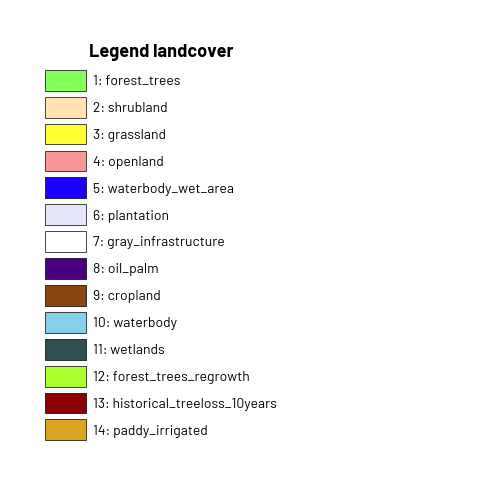

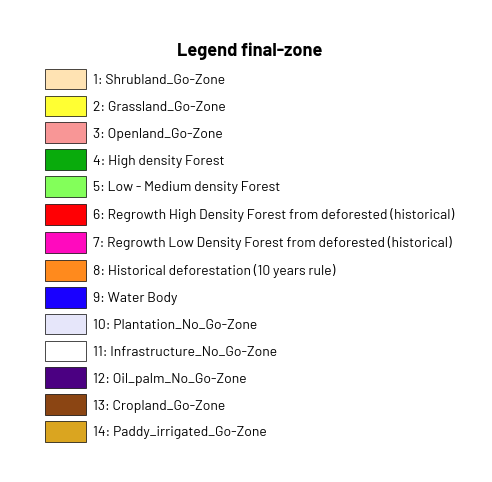

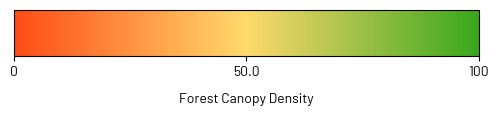

In [50]:
# legend lc
legend_class_lc = LegendsBuilder(legend_items=legend_items_lc)
legend_class_lc.create_legend('landcover')

# legend zone
legend_class_zone = LegendsBuilder(legend_items=legend_items)
legend_class_zone.create_legend('final-zone')

# custom color spectrum - override example
legend_class_lc.create_colorbar('Forest Canopy Density',{'min': 0, 'max': 100, 'palette': ['#ff4c16', '#ffd96c', '#39a71d']})

In [51]:
# give some break of cell just to ensure if you want to export or not

In [52]:
# give some break of cell just to ensure if you want to export or not

In [53]:
# give some break of cell just to ensure if you want to export or not

In [54]:
# give some break of cell just to ensure if you want to export or not

In [ ]:
######### EXPORTING
### NO NEED TO TO IT AGAIN IF THERE IS NO CHANGES

from osi.exporting_ee.main import exporting_from_ee

training_points_pathexport = exporting_from_ee(input_data = training_points, 
                                  type_data_export='vector', 
                                  output='shp',
                                  name_file_desc=f'training_points_{project_name}', 
                                  folder_name=f'result_lu_class_zone_{project_name}' )

validation_points_pathexport = exporting_from_ee(input_data = validation_points, 
                                  type_data_export='vector', 
                                  output='shp',
                                  name_file_desc=f'validation_points_{project_name}', 
                                  folder_name=f'result_lu_class_zone_{project_name}' )

# exporting to the vectors
final_zone_vector = final_zone.select('Class').reduceToVectors(
    geometryType='polygon',
    reducer=ee.Reducer.countEvery(),
    scale=pca_scale,
    maxPixels=1e10,
    geometry=AOI  # Add geometry parameter
)

selected_class_zone_pathexport = exporting_to_ee(input_data = final_zone_vector, 
                                  type_data_export='vector', 
                                  output='shp',
                                  name_file_desc=f'zone_result_{project_name}_{algo_ml_selected}_{config["super_pixel_size"]}_cluster', 
                                  folder_name=f'result_lu_class_zone_{project_name}' )


In [ ]:
# # Export the image to Google Drive as a GeoTIFF
# export_task = ee.batch.Export.image.toDrive(
#     image=object_properties_image,  # Clip the image to the ROI
#     description=f'cluster_{project_name}_{algo_ml_selected}_{config["super_pixel_size"]}m',  # Description for the export task
#     folder=f'result_input_{project_name}',  # Optional: Folder in Google Drive to save the file
#     fileNamePrefix=f'cluster_{project_name}_{algo_ml_selected}_{config["super_pixel_size"]}m',  # File name prefix for the exported TIFF
#     region=AOI.geometry().getInfo()['coordinates'],  # The region to export (in GeoJSON format)
#     scale=pca_scale,  # Pixel resolution in meters (e.g., 10 for Sentinel-2)
#     crs='EPSG:4326',  # Coordinate reference system (e.g., WGS84)
#     maxPixels=1e13,  # Maximum number of pixels allowed for the export
#     fileFormat='GeoTIFF'  # File format for the exported image
# )

# # Start the export task
# export_task.start()

# # Monitor the task status
# import time
# while export_task.active():
#     print('Export task status:', export_task.status())
#     time.sleep(10)

# print(f'Export task completed')

cluster_path_exported = exporting_to_ee(input_data = object_properties_image, 
                                  type_data_export='raster', 
                                  output='GeoTIFF',
                                  name_file_desc=f'cluster_{project_name}_{algo_ml_selected}_{config["super_pixel_size"]}m', 
                                  folder_name=f'result_input_{project_name}',
                                  AOI = AOI,
                                  pca_scale=pca_scale )


In [55]:
## DEEP LEARNING start with Tensorflow!!!!!
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.mask import mask
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
import numpy as np

arc_ops.list_layers = map.listLayers()
arc_ops.list_source_layers_in_map = [safe_get_data_source(layer) for layer in arc_ops.list_layers]

# load class label training - 
# STATIC HARD CODED, SINCE PROBABLY NEXT RUN WE DONT WANT TO RUN THE SCRIPT FROM THE BEGINNING (NO NEED TO DO EXPORTING AGAIN)
# if you want to change just uncomment the first one os.path.join
# path_training = os.path.join('G:',training_points_pathexport)
path_training = 'G:\\My Drive\\result_lu_class_zone_belaban_rayak\\training_points_belaban_rayak.shp'
# path_validation = os.path.join('G:',validation_points_pathexport)
path_validation = 'G:\\My Drive\\result_lu_class_zone_belaban_rayak\\validation_points_belaban_rayak.shp'
# path_training

# Load the raster data (TIFF) with multiple bands
raster_path = r"G:\My Drive\result_input_belaban_rayak\cluster_belaban_rayak_gbm_3m.tif"
# raster_path = os.path.join('G:',cluster_path_exported)

# Function to extract pixel values for each point in the shapefile
def extract_raster_values(raster, points):
    values = []
    labels = []
    for index, point in points.iterrows():
        # Convert point geometry to rasterio-friendly format
        coords = [point.geometry]
        
        # Mask the raster using the point geometry to get pixel values
        out_image, out_transform = mask(raster, coords, crop=True)
        
        # Flatten and extract pixel values
        pixel_values = out_image[:, 0, 0]  # Extract values from the masked array
        values.append(pixel_values)
        
        # Extract class label
        labels.append(point['code_lu'])  # Replace 'class_label' with your label column name

    return np.array(values), np.array(labels)

def run_simpleDL_tensorflow(path_training, path_validation, raster_path, epochs=100):
    raster = rasterio.open(raster_path)
    training_points = gpd.read_file(path_training)
    validation_points = gpd.read_file(path_validation)

    # Get unique values from 'code_lu' column in each GeoDataFrame
    unique_code_lu_training = training_points['code_lu'].unique()
    unique_code_lu_validation = validation_points['code_lu'].unique()

    # Combine unique values from both GeoDataFrames and get unique values again
    combined_unique_code_lu = list(set(unique_code_lu_training) | set(unique_code_lu_validation))

    label_unique_array = np.array(combined_unique_code_lu)

    # Print the combined unique values of 'code_lu'
    print("Unique 'code_lu' values from both shapefiles:", combined_unique_code_lu)
    # Display the mapping
    print("Original labels:", label_unique_array) # dealing with the 1,2,3,4,9 --> 9 give error

    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Fit and transform the labels to consecutive integers (0, 1, 2, 3, 4)
    encoded_labels = label_encoder.fit_transform(label_unique_array)
    print("Encoded labels:", encoded_labels)
    
    # Extract input features (raster pixel values) and output labels (class labels) for training and validation sets
    X_train, y_train = extract_raster_values(raster, training_points)
    X_val, y_val = extract_raster_values(raster, validation_points)

    # Fit and transform the labels to consecutive integers (0, 1, 2, 3, ...)
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)  # Use the same encoder to transform validation labels

    # Build a simple neural network model using TensorFlow
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
        tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer
        tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer
        tf.keras.layers.Dense(len(np.unique(y_train_encoded)), activation='softmax')  # Output layer (softmax for multi-class classification)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model with encoded labels
    history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=32, validation_data=(X_val, y_val_encoded))

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
    print(f'Validation Accuracy: {val_accuracy:.2f}')
    
# raster on cluster
run_simpleDL_tensorflow(path_training, path_validation, raster_path, epochs=100)

Unique 'code_lu' values from both shapefiles: [1, 2, 3, 4, 9]
Original labels: [1 2 3 4 9]
Encoded labels: [0 1 2 3 4]
Epoch 1/100
5/5 [==============================] - 1s 62ms/step - loss: 12.8242 - accuracy: 0.2180 - val_loss: 11.3477 - val_accuracy: 0.2985
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 8.4495 - accuracy: 0.4511 - val_loss: 9.3907 - val_accuracy: 0.3284
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 5.5430 - accuracy: 0.4436 - val_loss: 4.4748 - val_accuracy: 0.4776
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 3.2897 - accuracy: 0.5038 - val_loss: 2.7533 - val_accuracy: 0.4478
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 2.1046 - accuracy: 0.5113 - val_loss: 1.8291 - val_accuracy: 0.4030
Epoch 6/100
5/5 [==============================] - 0s 15ms/step - loss: 1.2455 - accuracy: 0.5639 - val_loss: 1.6643 - val_accuracy: 0.5075
Epoch 7/100
5/5 [======================

In [56]:
# # Export the all image to Google Drive as a GeoTIFF - takes time to export, no need to export again
# export_task = ee.batch.Export.image.toDrive(
#     image=image_norm_with_spectral_indices_FCD,  # Clip the image to the ROI
#     description=f'image_all_{project_name}_normalized',  # Description for the export task
#     folder=f'result_input_{project_name}',  # Optional: Folder in Google Drive to save the file
#     fileNamePrefix=f'image_all_{project_name}_normalized',  # File name prefix for the exported TIFF
#     region=AOI.geometry().getInfo()['coordinates'],  # The region to export (in GeoJSON format)
#     scale=pca_scale,  # Pixel resolution in meters (e.g., 10 for Sentinel-2)
#     crs='EPSG:4326',  # Coordinate reference system (e.g., WGS84)
#     maxPixels=1e13,  # Maximum number of pixels allowed for the export
#     fileFormat='GeoTIFF'  # File format for the exported image
# )

# # Start the export task
# export_task.start()

# # Monitor the task status
# import time
# while export_task.active():
#     print('Export task status:', export_task.status())
#     time.sleep(10)

# print(f'Export task completed')

In [57]:
# STATIC HARD CODED PATH, REMEMBER TO EDIT THIS
raster_pixel = r"G:\My Drive\result_input_belaban_rayak\image_all_belaban_rayak_normalized.tif"
# raster on cluster
run_simpleDL_tensorflow(path_training, path_validation, raster_pixel, epochs=100)

Unique 'code_lu' values from both shapefiles: [1, 2, 3, 4, 9]
Original labels: [1 2 3 4 9]
Encoded labels: [0 1 2 3 4]
Epoch 1/100
5/5 [==============================] - 1s 43ms/step - loss: 4.5423 - accuracy: 0.2030 - val_loss: 1.5542 - val_accuracy: 0.5373
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 1.2217 - accuracy: 0.5038 - val_loss: 1.0939 - val_accuracy: 0.6567
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 0.7198 - accuracy: 0.7519 - val_loss: 0.8460 - val_accuracy: 0.7463
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6892 - accuracy: 0.7293 - val_loss: 0.8118 - val_accuracy: 0.7612
Epoch 5/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6787 - accuracy: 0.7068 - val_loss: 0.6471 - val_accuracy: 0.7463
Epoch 6/100
5/5 [==============================] - 0s 14ms/step - loss: 0.5411 - accuracy: 0.7970 - val_loss: 0.6021 - val_accuracy: 0.7164
Epoch 7/100
5/5 [========================

In [5]:
# arcgis deeplearning
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import os
import shutil
from pathlib import Path
from arcgis.learn import prepare_data, SingleShotDetector
import matplotlib.pyplot as plt
import cv2

# Load the training point shapefile
path_training = 'G:\\My Drive\\result_lu_class_zone_belaban_rayak\\training_points_belaban_rayak.shp' 
gdf_training = gpd.read_file(path_training)

# Load the raster data
raster_path = r"G:\My Drive\result_input_belaban_rayak\cluster_belaban_rayak_gbm_3m.tif" # cluster image path exported from gee
raster = rasterio.open(raster_path)


In [12]:
# Create directories to store image chips and annotation files
# Get the current environment workspace
current_workspace = arcpy.env.workspace
# root_dir = os.path.dirname(current_workspace)
root_dir = r'C:\Users\q_bal\Documents\ArcGIS\scratch'
print('workspace: ', root_dir)

output_folder = os.path.join(root_dir,'exported_training_data')
chips_folder = os.path.join(output_folder, 'images')
annotations_folder = os.path.join(output_folder, 'labels')
os.makedirs(chips_folder, exist_ok=True)
os.makedirs(annotations_folder, exist_ok=True)

import cv2
import numpy as np

# Example code to handle different channel cases
chip_image = np.moveaxis(chip, 0, -1)  # Convert to (H, W, C) format if needed

# Convert to uint8 type and ensure correct range [0, 255]
chip_image = ((chip_image - chip_image.min()) / (chip_image.max() - chip_image.min()) * 255).astype(np.uint8)

# Check the number of channels
if len(chip_image.shape) == 2:
    # Single-channel image (grayscale)
    print("Converting single-channel image to 3-channel BGR...")
    chip_image = cv2.cvtColor(chip_image, cv2.COLOR_GRAY2BGR)
elif chip_image.shape[2] == 1:
    # Convert single-channel image to 3-channel BGR
    print("Converting single-channel image to 3-channel BGR...")
    chip_image = cv2.cvtColor(chip_image, cv2.COLOR_GRAY2BGR)
elif chip_image.shape[2] not in [3, 4]:
    raise ValueError(f"Invalid number of channels: {chip_image.shape[2]}")

# Save the image using cv2.imwrite
cv2.imwrite(chip_path, chip_image)

if np.isnan(chip_image).any() or np.isinf(chip_image).any():
    raise ValueError("Image contains NaN or infinite values.")

# Function to extract pixel values and save image chips around each point
def extract_chip(raster, point, buffer_size=128, chip_size=256):
    coords = [point.geometry.buffer(buffer_size).envelope]  # Create a square buffer around the point
    out_image, out_transform = mask(raster, coords, crop=True)  # Mask the raster to the buffered point
    if out_image.shape[1] < chip_size or out_image.shape[2] < chip_size:
        return None  # Skip chips that are smaller than desired size
    # Extract the center part to get fixed-size chips
    center_x, center_y = out_image.shape[1] // 2, out_image.shape[2] // 2
    chip = out_image[:, center_x-chip_size//2:center_x+chip_size//2, center_y-chip_size//2:center_y+chip_size//2]
    return chip

# Iterate over each point in the shapefile and create image chips
for idx, point in gdf_training.iterrows():
    chip = extract_chip(raster, point)
    if chip is not None:
        # Save the chip as an image
        chip_path = os.path.join(chips_folder, f'chip_{idx}.png')
        # Transpose the image to (H, W, C) and normalize
        chip_image = np.moveaxis(chip, 0, -1)
        chip_image = ((chip_image - chip_image.min()) / (chip_image.max() - chip_image.min()) * 255).astype(np.uint8)
        cv2.imwrite(chip_path, chip_image)

        # Save the annotation file (e.g., in PASCAL VOC format)
        annotation_path = os.path.join(annotations_folder, f'chip_{idx}.xml')  # Placeholder example
        with open(annotation_path, 'w') as f:
            f.write(f'<annotation><filename>chip_{idx}.png</filename></annotation>')

workspace:  C:\Users\q_bal\Documents\ArcGIS\scratch


ValueError: Invalid number of channels: 15

In [9]:
os.path.dirname(current_workspace)

'G:\\My Drive\\TreeO_WORKS\\GIS_data\\ArcGIS_Pro\\TREEO'

In [47]:
from osi.spectral_indices.utils import assigning_band
from osi.classifying.utils import add_classes, add_images, select_band_if_exists, unmasked_helper

forest_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(1))
shrub_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(2))
grass_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(3))
openland_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(4))
water_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(5))
plantation_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(6))
infrastructure_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(7))
oil_palm_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(8))
cropland_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(9))
paddy_irigated_masked = selected_image_lc.updateMask(selected_image_lc.select(['classification']).eq(14))# arc_ops.adding_ee_to_arcgisPro(infrastructure_masked.randomVisualizer(),{},'test')

def unmasked_helper(image, AOI_img, AOI):
    mask_image = image.mask()
    mask_image_inverted = mask_image.Not()
    unmasked_image = AOI_img.unmask().updateMask(mask_image_inverted).clip(AOI)
    return unmasked_image

#sub-forest considering the fcd threshold of high density forest, regardless the ML method
# HighForestDense = FCD.mask(FCD.gte(high_forest).And(unmaskedWaterAOI))
unmaskedHighForest = AOI_img.unmask().updateMask(HighForestDense.mask().Not()).clip(AOI)
yrf_forest = forest_masked.And(unmaskedHighForest)
high_forest_fix = HighForestDense.And(forest_masked)

band_name_image = config['band_name_image']

######### general go-zone
## Starting to retrieve from 10 TCL unmask
unmaskedLoss = unmasked_helper(minLoss, AOI_img, AOI)
# Unmasked Forest - the result is all the area outside of forest_masked (Total all forest), and now in no forest
# maskHiF = forest_masked.mask()
# maskHiF_inverted = maskHiF.Not()
# unmaskedHiF = AOI_img.unmask().updateMask(maskHiF_inverted).clip(AOI)
unmaskedHiF = unmasked_helper(forest_masked, AOI_img, AOI)
# unmasked water
waterinAOI = water_masked
unmaskedWaterAOI = unmasked_helper(water_masked, AOI_img, AOI)
# unmasked grey infrastructure
unmasked_infrastructure = unmasked_helper(infrastructure_masked, AOI_img, AOI)
# unmasked oil palm
unmasked_oilpalm = unmasked_helper(oil_palm_masked, AOI_img, AOI)

goZone = unmaskedLoss.And(unmaskedHiF).And(unmaskedWaterAOI).And(unmasked_infrastructure).And(unmasked_oilpalm)
goZone_edited = ee.Image(assigning_band(config['band_name_image'],999,goZone))

# forest category and no 10 years rule
highBaselineF = forest_masked.And(unmaskedLoss)
highf_edited = ee.Image(assigning_band(config['band_name_image'],111,highBaselineF))

####### Get the overlay information of HighBaseline and Tree Cover Loss (Hansen), e.g., Young Regenerating Forest
HiForestAndLoss = AOI_img.And(forest_masked.And(minLoss)) #minLoss is the actual TCL without overlaying with Sentinel
tenyrfl_edited = ee.Image(assigning_band(band_name_image,888,HiForestAndLoss))
# arc_ops.adding_ee_to_arcgisPro(tenyrfl_edited.randomVisualizer(),{},'tenyrlfl_edited')

# Create a helper mask indicating where the smaller areas maskhiFL, distinguish only the highbaseline and TCL (mask) and assign mask as 1
# Unmask the bigger raster in the areas to get the pixel value for area 'outside' HiFL (High Baseline and Forest Loss)
unmaskedHiFL = unmasked_helper(HiForestAndLoss, AOI_img, AOI)
#outcome result for 10 years data only that is not overlay with high baseline (Forest) unmaskedHiFL is Area that is not Forest Sentinel############
tenYearsRule = unmaskedHiFL.And(minLoss)
tenyrule_edited = ee.Image(assigning_band(band_name_image,8,tenYearsRule))
# arc_ops.adding_ee_to_arcgisPro(tenyrule_edited.randomVisualizer(),{},'tenyrule_edited')

#re-acquired the same method for 10 years rule data (GFW or Hansen data (pixel 30m))
#assigning to zones:
## GO ZONE
Shrubland_gozone = shrub_masked.And(goZone_edited).select(['pixel'])
Shrubland_gozone = ee.Image(assigning_band(config['band_name_image'],1,Shrubland_gozone))

Grassland_gozone = grass_masked.And(goZone_edited).select(['pixel'])
Grassland_gozone = ee.Image(assigning_band(config['band_name_image'],2,Grassland_gozone))

Openland_gozone = openland_masked.And(goZone_edited).select(['pixel'])
Openland_gozone = ee.Image(assigning_band(config['band_name_image'],3,Openland_gozone))

Openland_gozone = openland_masked.And(goZone_edited).select(['pixel'])
Openland_gozone = ee.Image(assigning_band(config['band_name_image'],3,Openland_gozone))

Cropland_Gozone = cropland_masked.And(goZone_edited).select(['pixel'])
Cropland_Gozone = ee.Image(assigning_band(config['band_name_image'],13,Cropland_Gozone))

Paddy_Gozone = paddy_irigated_masked.And(goZone_edited).select(['pixel'])
Paddy_Gozone = ee.Image(assigning_band(config['band_name_image'],14,Paddy_Gozone))

## NO GO additional
Plantation_noGozone = plantation_masked.And(goZone_edited).select(['pixel'])
Plantation_noGozone = ee.Image(assigning_band(config['band_name_image'],10,Plantation_noGozone))

Infrastructure_noGozone = infrastructure_masked.And(goZone_edited).select(['pixel'])
Infrastructure_noGozone = ee.Image(assigning_band(config['band_name_image'],11,Infrastructure_noGozone))

Oilpalm_noGozone = oil_palm_masked.And(goZone_edited).select(['pixel'])
Oilpalm_noGozone = ee.Image(assigning_band(config['band_name_image'],12,Oilpalm_noGozone))

# highbaseline
# HighForestDense = FCD.mask(FCD.gte(high_forest).And(unmaskedWaterAOI))
HighForestDense_no10yrs = HighForestDense.And(highf_edited).select(['pixel'])
HighForestDense_no10yrs = ee.Image(assigning_band(config['band_name_image'],4,HighForestDense_no10yrs))

#YRFForestDense = FCD.mask(FCD.gte(yrf_forest).And(unmaskedWaterAOI).And(FCD.lt(high_forest)))
YRFForestDense_no10yrs = yrf_forest.And(highf_edited).select(['pixel'])
YRFForestDense_no10yrs = ee.Image(assigning_band(config['band_name_image'],5,YRFForestDense_no10yrs))
##########################

# high baseline regrowth
HighForestDense_10yrs = HighForestDense.And(tenyrfl_edited).select(['pixel'])
HighForestDense_10yrs = ee.Image(assigning_band(config['band_name_image'],6,HighForestDense_10yrs))

YRFForestDense_10yrs = yrf_forest.And(tenyrfl_edited).select(['pixel'])
YRFForestDense_10yrs = ee.Image(assigning_band(config['band_name_image'],7,YRFForestDense_10yrs))
############################

# 10 years rule, straight forward
# tenyrule_edited = ee.Image(assigning_band(band_name_image,8,tenYearsRule)) #tenyears rule not pass - 8  # already hard-coded set in the previous function
No_pass_historical_years_rule = tenyrule_edited.select([config['band_name_image']])

# Filter the images based on the 'Class' band, and add them one by one on map canvas!!!!!!!!!!!!!!!!!!!! # just comment this Map.addLayer if you want not to display one by one
openland_gozone = Openland_gozone.select([config['band_name_image']])
# Map.addLayer(openland_gozone,{'palette': ['#F89696']},'Open land - Go Zone')

grassland_gozone = Grassland_gozone.select([config['band_name_image']])
# Map.addLayer(grassland_gozone,{'palette': ['#ffff33']},'Grass land - Go Zone')

shrubland_gozone = Shrubland_gozone.select([config['band_name_image']])
# Map.addLayer(shrubland_gozone,{'palette': ['#ffe3b3']},'Shrub land - Go Zone')

yrf_forest_dense_no10yrs = YRFForestDense_no10yrs.select([config['band_name_image']])
# Map.addLayer(yrf_forest_dense_no10yrs,{'palette': ['#83ff5a']},'Low-Med Forest')

high_forest_dense_no10yrs = HighForestDense_no10yrs.select(config['band_name_image'])
# Map.addLayer(high_forest_dense_no10yrs,{'palette': ['#09ab0c']},'High- Density Forest')

yrf_forest_dense_10yrs = YRFForestDense_10yrs.select([config['band_name_image']])
# Map.addLayer(yrf_forest_dense_10yrs,{'palette': ['#ff0abe']},'Re-growth Low-Med Density Forest')

high_forest_dense_10yrs = HighForestDense_10yrs.select([config['band_name_image']])
# Map.addLayer(high_forest_dense_10yrs,{'palette': ['#ff0004']},'Re-growth High Density Forest')

No_pass_historical_years_rule = tenyrule_edited.select([config['band_name_image']])
# Map.addLayer(No_pass_historical_years_rule,{'palette': ['#ff8a1d']},'Historical deforestation no regrowth (3 or 10 years)')

# since there are case water from mining (overlap 10 years rule with water), we should unmasked first
unmasked10years = AOI_img.unmask().updateMask(No_pass_historical_years_rule.mask().Not()).clip(AOI)
water_no_10yr = waterinAOI.And(unmasked10years).And(unmasked10years)
Water_Un_plantable = ee.Image(assigning_band(config['band_name_image'],9,water_no_10yr)).select(config['band_name_image'])

# Map.addLayer(Water_Un_plantable,{'palette': ['#1900ff']},'Water body (unplantable)')

# Example band name to check
band_name = config['band_name_image']

# Select images if the band exists
plantation_noGozone = select_band_if_exists(Plantation_noGozone, band_name)
infrastructure_noGozone = select_band_if_exists(Infrastructure_noGozone, band_name)
oilpalm_noGozone = select_band_if_exists(Oilpalm_noGozone, band_name)
cropland_Gozone = select_band_if_exists(Cropland_Gozone, band_name)
paddy_Gozone = select_band_if_exists(Paddy_Gozone, band_name)

empty_image = ee.Image.constant(0).rename(config['band_name_image'])

image_list_result = [
    openland_gozone,
    grassland_gozone,
    shrubland_gozone,
    high_forest_dense_no10yrs,
    yrf_forest_dense_no10yrs,
    high_forest_dense_10yrs,
    yrf_forest_dense_10yrs,
    No_pass_historical_years_rule,
    Water_Un_plantable,
    plantation_noGozone,
    infrastructure_noGozone,
    oilpalm_noGozone,
    cropland_Gozone,
    paddy_Gozone

]

# Remove None entries from the list
image_list_result = [img for img in image_list_result if img is not None]

# Create an ImageCollection from the list of images
image_collection_result = ee.ImageCollection(image_list_result)

# Apply the add_classes function to each image in the collection while merging them into the 'empty_image'
result_collection_with_class = image_collection_result.map(lambda image: add_classes(image, empty_image))

# Merge all the images in the result_collection using ee.ImageCollection.iterate()
merged_image_result = ee.Image(result_collection_with_class.iterate(add_images, empty_image))

# Cast the merged image to Int32 and set the original Class band name
merged_image_result = merged_image_result.toInt32().rename('Class')
merged_image_result = merged_image_result.clip(AOI)
final_zone_map = merged_image_result

arc_ops.adding_ee_to_arcgisPro(final_zone_map, vis_params_fcd_classified, f'Final_zone_ML_{algo_ml_selected}_Hansen')  # the naming probably will need to change, for some concistencies only so that you understand again later to read the codes


https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/59da9d50ab3f36c576d2d606a18a2bb5-ae0b70256353dbff90d9cff22433e4dc/tiles/{z}/{x}/{y}
removing and re-adding the layer name: Final_zone_ML_gbm_Hansen
layer re-added: Final_zone_ML_gbm_Hansen


In [45]:
for i in image_list_result:
    print(i.bandNames().getInfo())
    print('----')

['Class']
----
['Class']
----
['Class']
----
['Class']
----
['Class']
----
['Class']
----
['Class']
----
['Class']
----
['Class', 'pixel']
----
['Class']
----
['Class']
----
['Class']
----
['Class']
----
['Class']
----


In [ ]:
Shrubland_gozone = shrub_masked.And(goZone_edited).select(['pixel'])
Shrubland_gozone = ee.Image(assigning_band(config['band_name_image'],1,Shrubland_gozone))
arc_ops.adding_ee_to_arcgisPro(Shrubland_gozone.randomVisualizer(),{},'Shrubland_gozone')


In [80]:
Paddy_Gozone = paddy_irigated_masked.And(goZone_edited).select(['pixel'])
Paddy_Gozone = ee.Image(assigning_band(config['band_name_image'],14,Paddy_Gozone))
arc_ops.adding_ee_to_arcgisPro(Paddy_Gozone.randomVisualizer(),{},'Paddy_Gozone')


https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/cfd6d00f3129b288819a3a87e754e3fc-cc3e835c648791ff451016605e6bb581/tiles/{z}/{x}/{y}


In [82]:
HighForestDense.bandNames().getInfo()

['FCD']

In [69]:
goZone_edited.bandNames().getInfo()

['Class', 'pixel']

EEException: Image.select: Band pattern 'pixel' did not match any bands. Available bands: [classification]